In [1]:
cd ..

/home/janek/mag/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import random
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data, reduce_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_tr_p2, data_vl_p2, idx_te, X_te, y_te = prepare_data(data_tr, data_vl, data_te, seed, 6)

In [5]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_tr_p2[2]))
print(np.mean(data_vl_p2[2]))
print(np.mean(y_te))

0.21727741729603234
0.20701168614357263

0.21858694494728995
0.19522240527182866
0.20294599018003273


In [6]:
print(len(data_tr[2]))
print(len(data_vl[2]))
print()
print(len(data_tr_p2[2]))
print(len(data_vl_p2[2]))
print(len(y_te))

75208
4792

37564
1214
1222


In [7]:
data_tr_p2 = reduce_dataset(data_tr_p2, len(test_onto), 1400, [idx_te, X_te, y_te])
data_tr = reduce_dataset(data_tr, len(train_onto), 1350, data_vl)
idx_te.extend(data_vl_p2[0])
X_te.extend(data_vl_p2[1])
y_te.extend(data_vl_p2[2])

In [8]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_tr_p2[2]))
print(np.mean(data_vl_p2[2]))
print(np.mean(y_te))

0.20594444444444446
0.20701168614357263

0.19907142857142857
0.19522240527182866
0.1990968801313629


In [9]:
print(len(data_tr[2]))
print(len(data_vl[2]))
print()
print(len(data_tr_p2[2]))
print(len(y_te))

54000
4792

28000
2436


In [10]:
emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

In [11]:
#FIRST PHASE
T.manual_seed(seed)
reasoner_original = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_original = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_original)} parameters')
print(f'created {len(encoders_original)} encoders with {paramcount(encoders_original[0])} parameters each')

T.manual_seed(seed)
reasoner_mod = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_mod = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_mod)} parameters')
print(f'created {len(encoders_mod)} encoders with {paramcount(encoders_mod[0])} parameters each')

train_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    random.seed(seed)
    if reasoner_name == 'original reasoner':
        train(data_tr, data_vl, reasoner, encoders_original, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger)
    else:
        train_mod(data_tr, data_vl, reasoner, encoders_mod, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger, identities_weight=0.028, identitity_weight_decay=0.96)


created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
original reasoner
train epoch 00/15 | batch 1689/1688 | loss 0.7214 | val loss 0.7207 | acc 0.2068 | f1 0.3427 | prec 0.2068 | recall 0.9990 | roc auc 0.5332 | pr auc 0.2351 | elapsed 16.69s
train epoch 01/15 | batch 1689/1688 | loss 0.5768 | val loss 0.4749 | acc 0.8024 | f1 0.1074 | prec 0.8261 | recall 0.0575 | roc auc 0.6702 | pr auc 0.3595 | elapsed 66.02s
train epoch 02/15 | batch 1689/1688 | loss 0.4498 | val loss 0.4338 | acc 0.8128 | f1 0.2807 | prec 0.6863 | recall 0.1764 | roc auc 0.7706 | pr auc 0.5028 | elapsed 62.35s
train epoch 03/15 | batch 1689/1688 | loss 0.3523 | val loss 0.4031 | acc 0.8397 | f1 0.4733 | prec 0.7403 | recall 0.3478 | roc auc 0.8158 | pr auc 0.6315 | elapsed 60.58s
train epoch 04/15 | batch 1689/1688 | loss 0.2757 | val loss 0.3793 | acc 0.8637 | f1 0.5937 | prec 0.7756 | recall 0.4808

In [12]:
## --- SECOND PHASE
trained_test_encoders = {}
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'original reasoner':
        train(data_tr_p2, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)
    else:
        train_mod(data_tr_p2, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)


original reasoner
train epoch 00/10 | batch 876/875 | loss 1.4058 | val loss 1.4058 | acc 0.5912 | f1 0.3791 | prec 0.2717 | recall 0.6270 | roc auc 0.6660 | pr auc 0.4692 | elapsed 9.76s
train epoch 01/10 | batch 876/875 | loss 1.2002 | val loss 0.9651 | acc 0.6773 | f1 0.4389 | prec 0.3356 | recall 0.6340 | roc auc 0.7309 | pr auc 0.5374 | elapsed 22.34s
train epoch 02/10 | batch 876/875 | loss 0.8227 | val loss 0.6529 | acc 0.7629 | f1 0.5242 | prec 0.4365 | recall 0.6561 | roc auc 0.7951 | pr auc 0.6196 | elapsed 24.15s
train epoch 03/10 | batch 876/875 | loss 0.5645 | val loss 0.4528 | acc 0.8303 | f1 0.6151 | prec 0.5606 | recall 0.6814 | roc auc 0.8500 | pr auc 0.7084 | elapsed 23.78s
train epoch 04/10 | batch 876/875 | loss 0.4029 | val loss 0.3311 | acc 0.8777 | f1 0.6977 | prec 0.6867 | recall 0.7090 | roc auc 0.8907 | pr auc 0.7865 | elapsed 23.82s
train epoch 05/10 | batch 876/875 | loss 0.3043 | val loss 0.2571 | acc 0.9086 | f1 0.7617 | prec 0.7920 | recall 0.7336 | roc a

In [13]:
with T.no_grad():
    _, _, Y_te_orig = eval_batch(reasoner_original, trained_test_encoders['original reasoner'], X_te, y_te, idx_te)
    _, _, Y_te_mod = eval_batch(reasoner_mod, trained_test_encoders['modified reasoner'], X_te, y_te, idx_te)

local/out/exp/20240808T184236


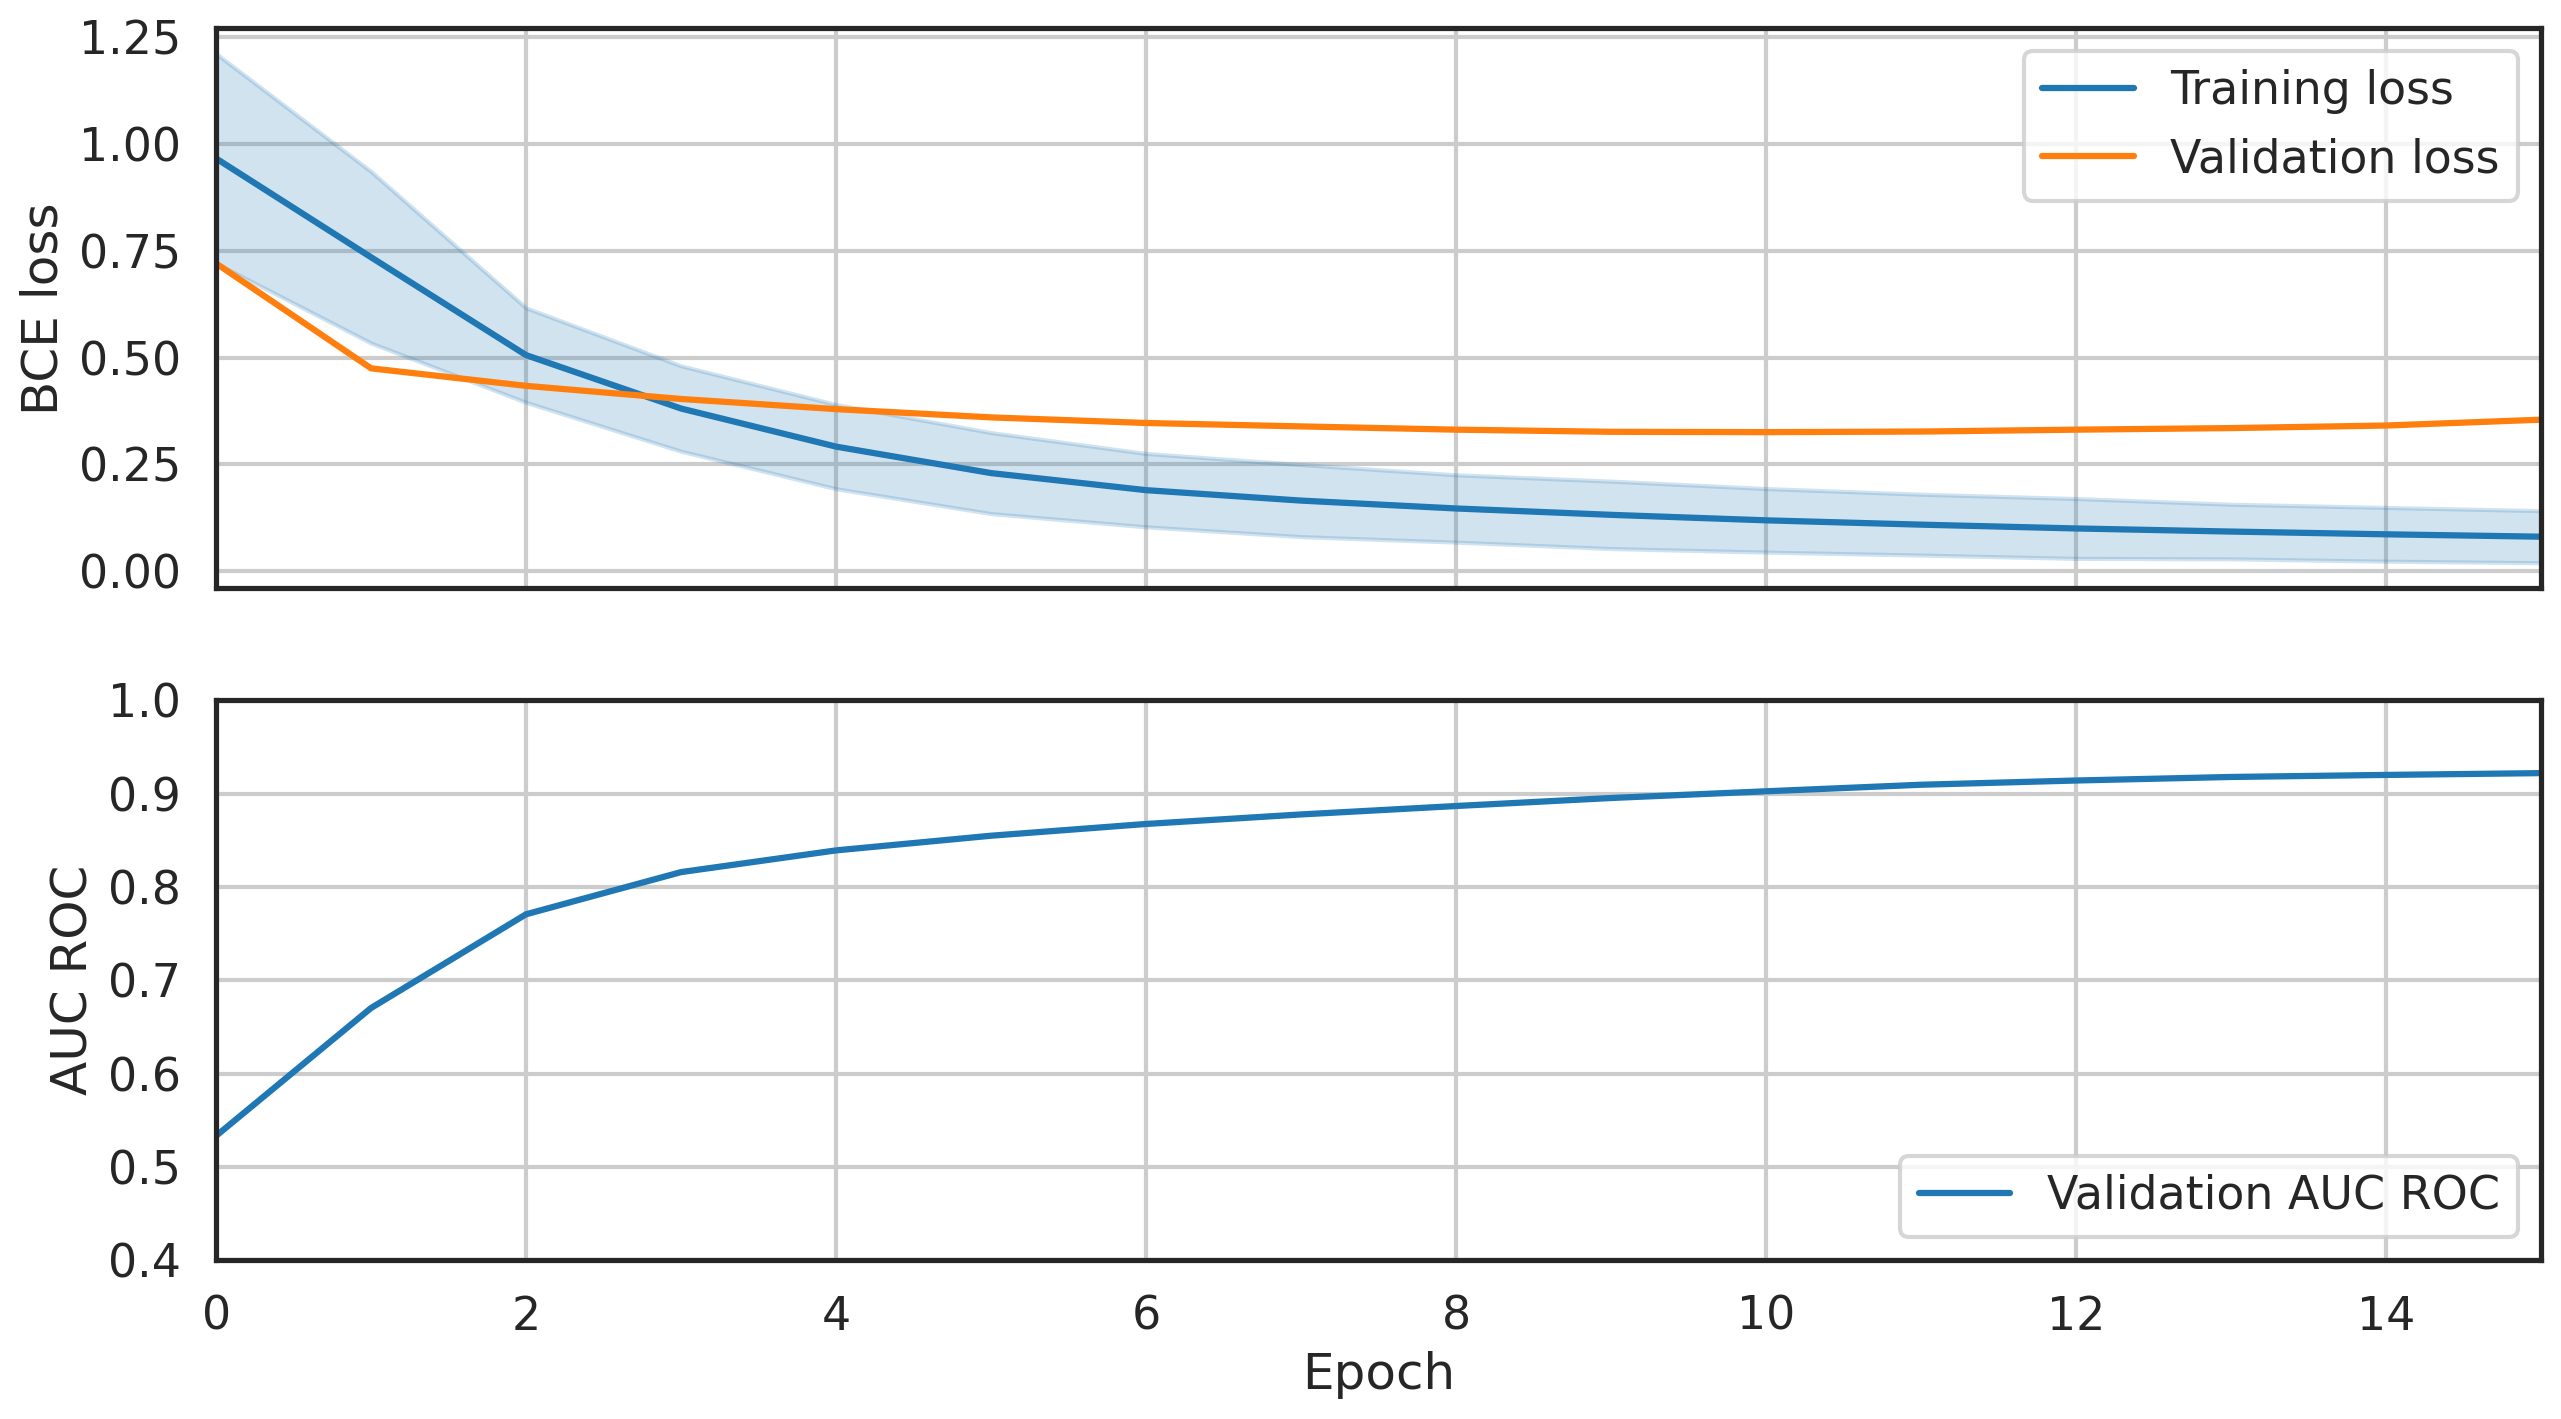

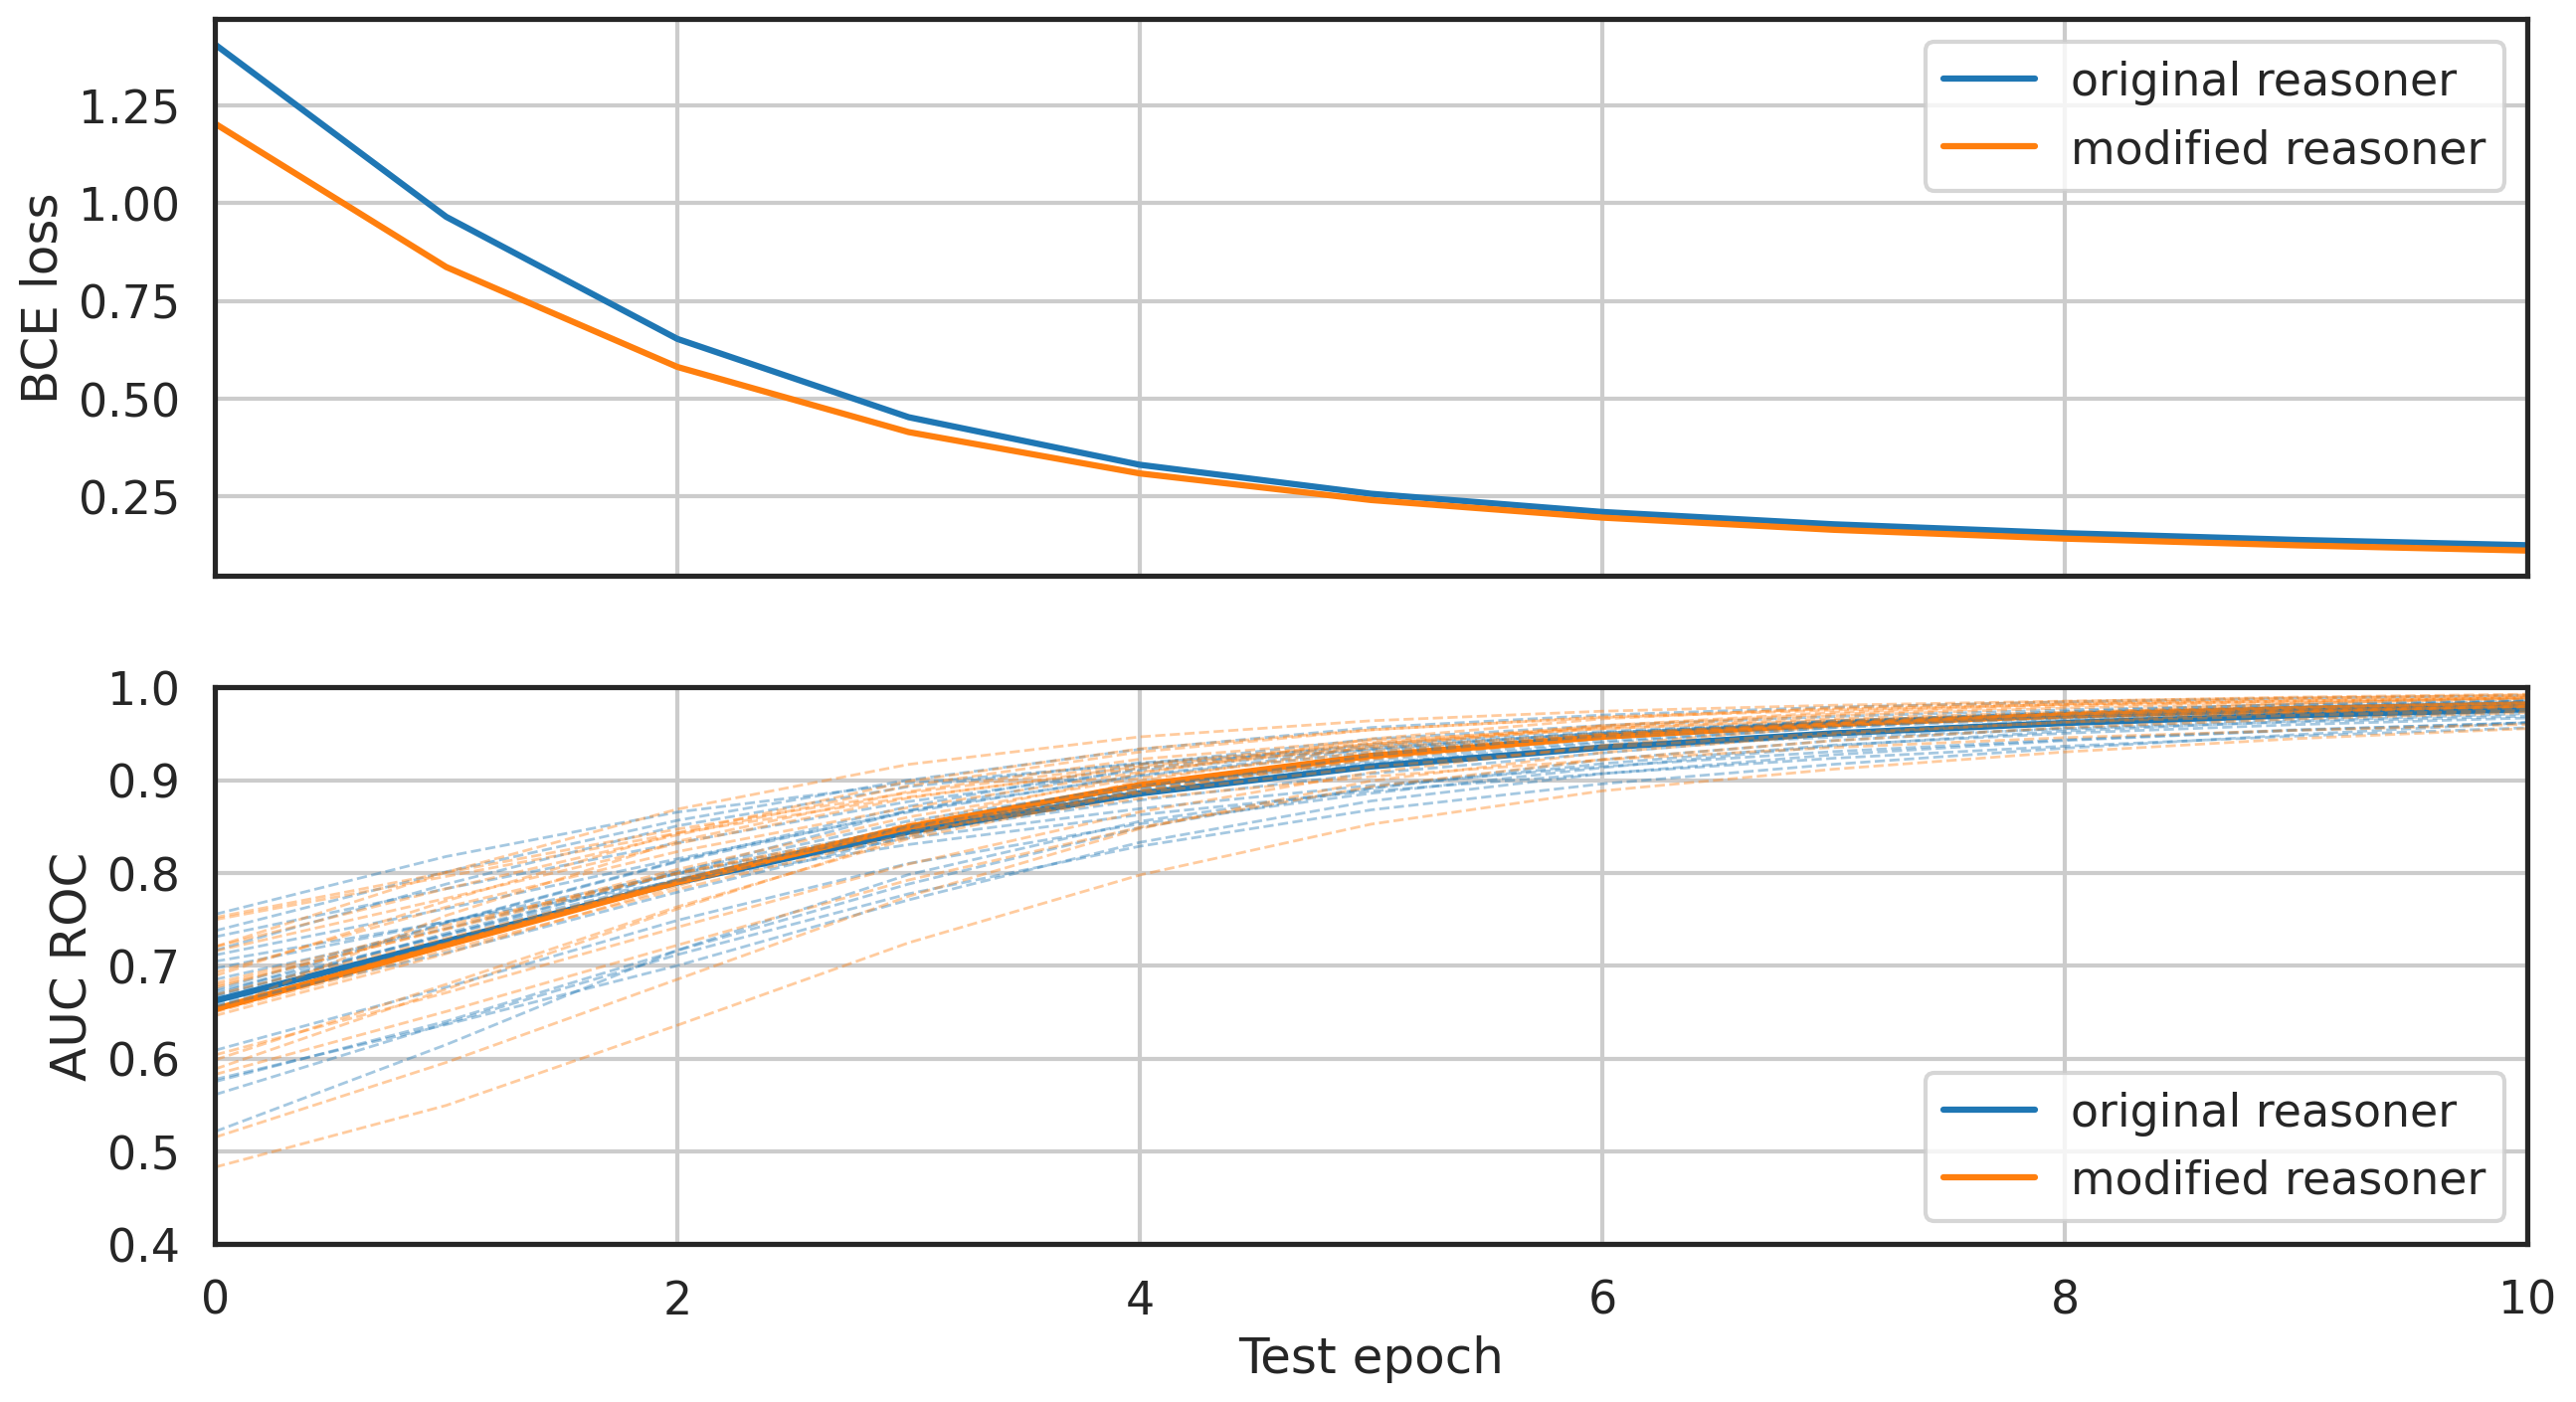

original
             mean       std     micro
acc      0.873965  0.044166  0.873974
prec     0.693894  0.131901  0.696903
recall   0.637961  0.150451  0.649485
f1       0.656305  0.119531  0.672359
auc_roc  0.866899  0.068809  0.873060
auc_pr   0.741268  0.131573  0.754727
modified
             mean       std     micro
acc      0.865942  0.035413  0.866585
prec     0.629146  0.114777  0.648699
recall   0.700419  0.130659  0.719588
f1       0.658361  0.109468  0.682307
auc_roc  0.890281  0.051005  0.894335
auc_pr   0.764174  0.115024  0.781681


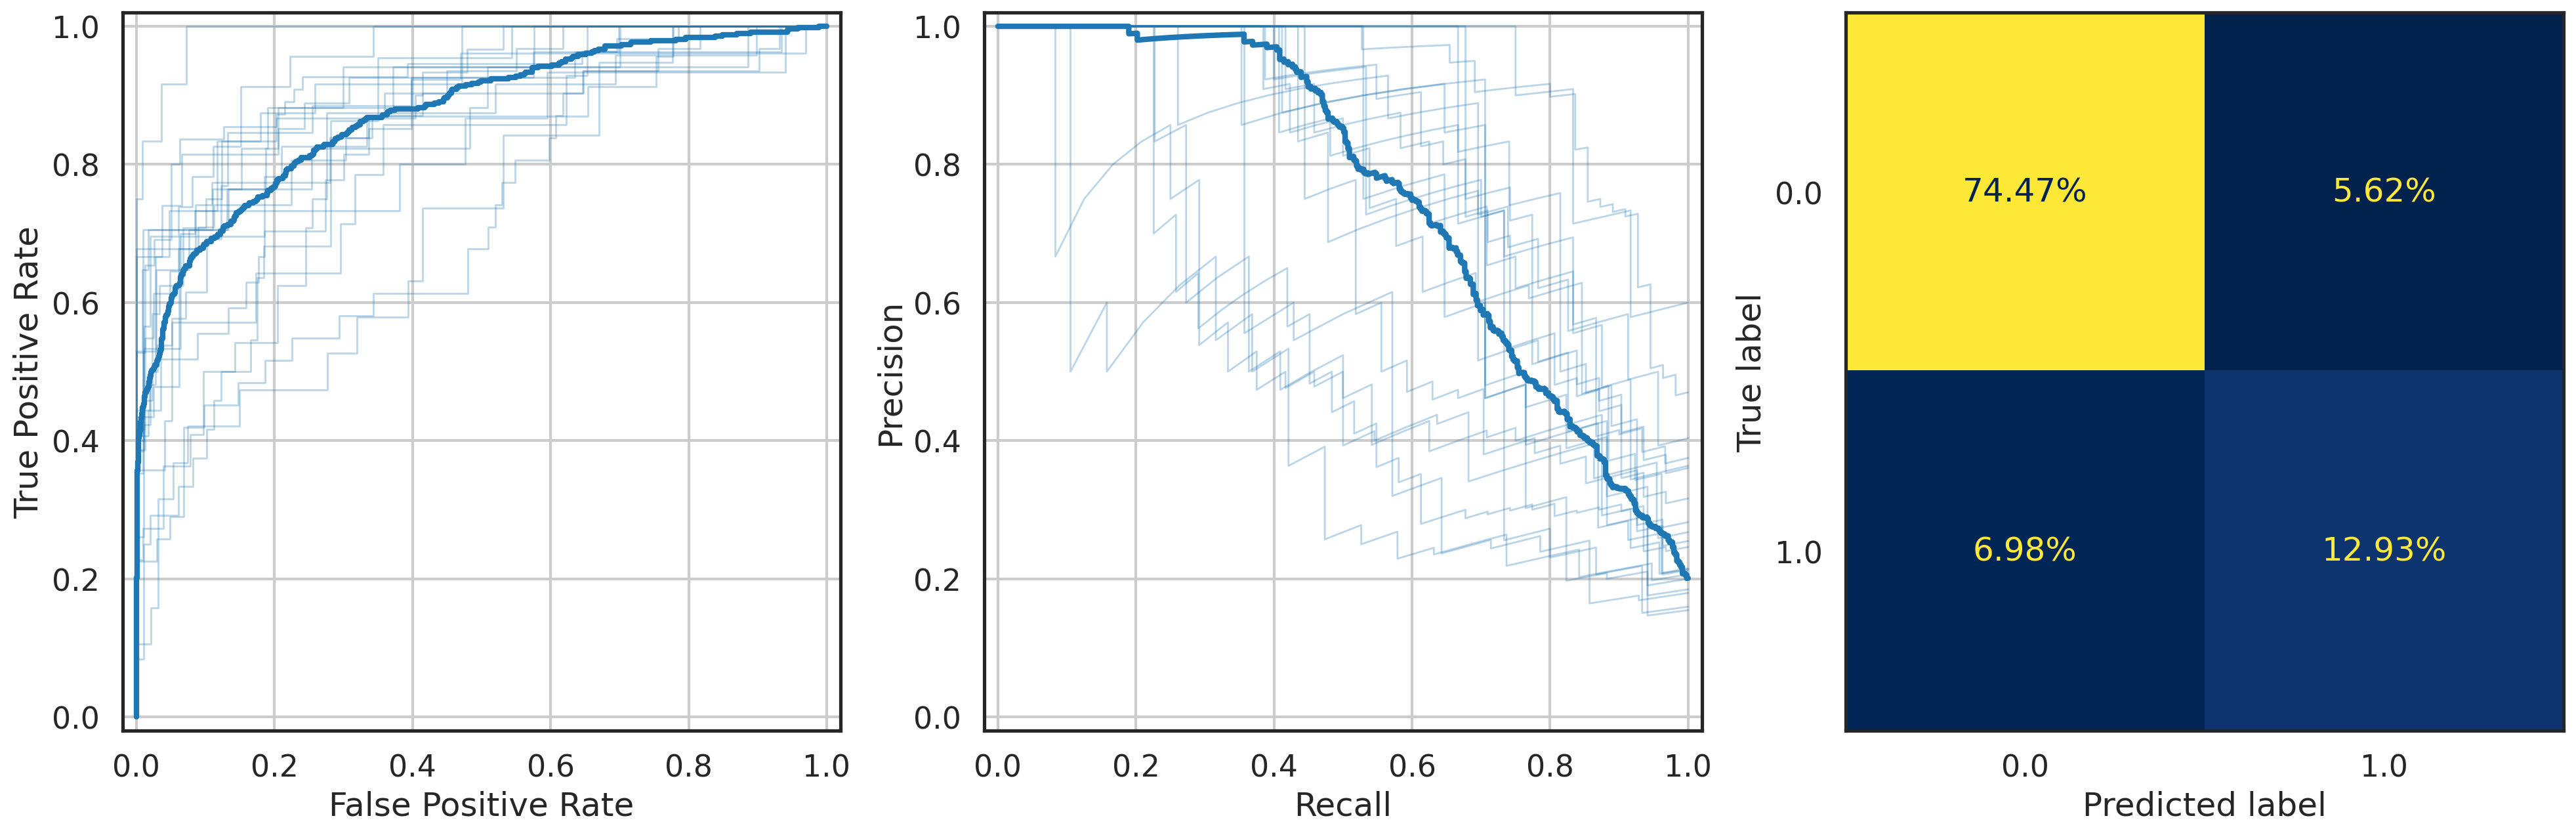

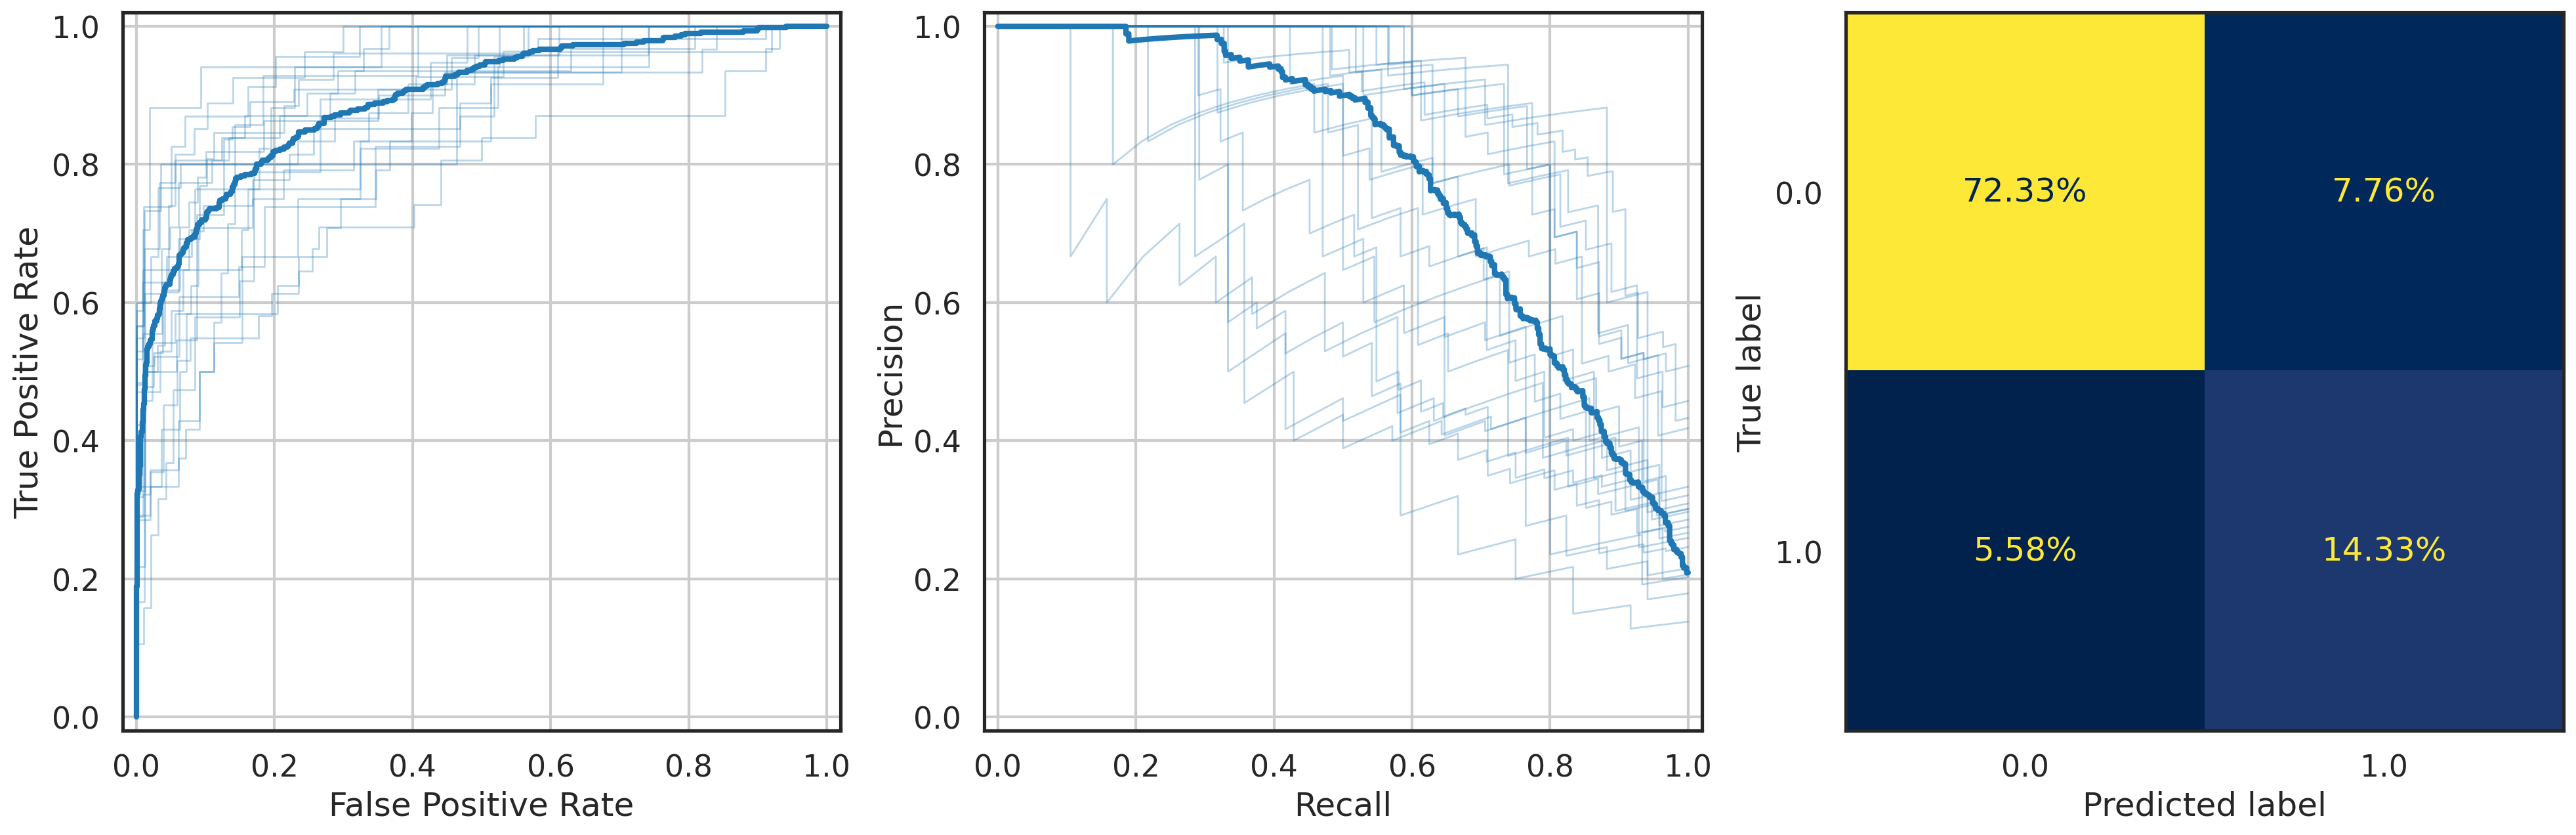

In [14]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(reasoner_original.state_dict(), base+'/reasonerO.pt')
T.save(reasoner_mod.state_dict(), base+'/reasonerM.pt')

df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_orig=Y_te_orig, Y_te_mod=Y_te_mod))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print('original')
print(report(test_onto, y_te, np.array(Y_te_orig), idx_te, save=base+'/%-trained'))
print('modified')
print(report(test_onto, y_te, np.array(Y_te_mod), idx_te, save=base+'/%-random'))

In [15]:
from src.id import print_identity_results
print(print_identity_results(reasoner_original,trained_test_encoders['original reasoner'], seed))

Double Negation:
  Mean Loss: 0.285691
  Std Dev Loss: 0.031313
  Mean Diff: 0.580905
  Std Dev Diff: 0.095630

Duality of Top and Bottom:
  Mean Loss: 0.379092
  Std Dev Loss: 0.000000
  Mean Diff: 0.696303
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.126674
  Std Dev Loss: 0.032443
  Mean Diff: 0.312626
  Std Dev Diff: 0.086752

Associativity:
  Mean Loss: 0.034176
  Std Dev Loss: 0.011678
  Mean Diff: 0.077955
  Std Dev Diff: 0.025542

Commutativity:
  Mean Loss: 0.037453
  Std Dev Loss: 0.012723
  Mean Diff: 0.087663
  Std Dev Diff: 0.032176

Contradiction:
  Mean Loss: 0.376971
  Std Dev Loss: 0.017715
  Mean Diff: 0.829072
  Std Dev Diff: 0.072713

Identity with Top:
  Mean Loss: 0.153828
  Std Dev Loss: 0.036253
  Mean Diff: 0.365930
  Std Dev Diff: 0.107835

Absorption by Bottom:
  Mean Loss: 0.427256
  Std Dev Loss: 0.018819
  Mean Diff: 0.811284
  Std Dev Diff: 0.037391

Top Concept Subsumption:
  Mean Loss: 0.001808
  Std Dev Loss: 0.002699
  Mean Diff: N/A
  Std De

In [16]:
print(print_identity_results(reasoner_mod,trained_test_encoders['modified reasoner'], seed))

Double Negation:
  Mean Loss: 0.000016
  Std Dev Loss: 0.000005
  Mean Diff: 0.000040
  Std Dev Diff: 0.000016

Duality of Top and Bottom:
  Mean Loss: 0.000492
  Std Dev Loss: 0.000000
  Mean Diff: 0.001510
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.115664
  Std Dev Loss: 0.027912
  Mean Diff: 0.270349
  Std Dev Diff: 0.075849

Associativity:
  Mean Loss: 0.021634
  Std Dev Loss: 0.007609
  Mean Diff: 0.048224
  Std Dev Diff: 0.016529

Commutativity:
  Mean Loss: 0.023969
  Std Dev Loss: 0.008581
  Mean Diff: 0.056802
  Std Dev Diff: 0.020972

Contradiction:
  Mean Loss: 0.149499
  Std Dev Loss: 0.037292
  Mean Diff: 0.242454
  Std Dev Diff: 0.042839

Identity with Top:
  Mean Loss: 0.067282
  Std Dev Loss: 0.018447
  Mean Diff: 0.160362
  Std Dev Diff: 0.050332

Absorption by Bottom:
  Mean Loss: 0.019974
  Std Dev Loss: 0.008777
  Mean Diff: 0.050522
  Std Dev Diff: 0.018929

Top Concept Subsumption:
  Mean Loss: 0.000924
  Std Dev Loss: 0.000868
  Mean Diff: N/A
  Std De